In [31]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%matplotlib notebook



In [32]:
from helper.shoot_ray_helper import ShootRayFromVect
from helper.geometry_helper import IsRightTurn, IsLeftTurn, AngleBetween
from helper.bounce_graph_helper import whichComponent
from simple_polygon import *
from partial_local_sequence import *
from bounce_visibility_diagram import *
from bounce_graph import *
from maps import *
from settings import *

import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt

import colorsys
import os
import subprocess


In [56]:

# compute whether transition is contracting and what the coefficient is
def isContraction(e1, e2, theta):
    [e1v1, e1v2] = e1
    [e2v1, e2v2] = e2
    phi = AngleBetween(e1v2-e1v1, e2v2-e2v1) # in range [0,pi]

    try:
        _, _, int_pt = ShootRayFromVect(e1v1, e1v2, e2v1, e2v2)
    except: # lines are parallel, inducing neutrally stable 2-period cycle
        return True, 1.0

    # determine handedness of transition

    # left transition, adjacent edges
    if la.norm(e1v1-e2v2) < EPSILON:
        c_th = np.sin(theta)/np.sin(theta+phi-np.pi)
    # right transition, adjacent edges
    elif la.norm(e1v2-e2v1) < EPSILON:
        c_th = np.sin(theta)/np.sin(phi-theta)
    # left transition
    elif IsLeftTurn(e1v1, e2v1, int_pt):
        c_th = np.sin(theta)/np.sin(theta+phi-np.pi)
    # right transition
    else:
        c_th = np.sin(theta)/np.sin(phi-theta)

    if abs(c_th) < 1.0:
        return True, c_th
    else:
        return False, c_th

def classifyBoundary(poly, theta):
    # divid each edge into small intervals, shoot ray from the end points of the interval, compute the ratio between the ray hit interval and the start interval

    def normalize(vector):
        norm = np.linalg.norm(vector)
        return vector/norm
    def rotate_vector(v, theta):
        vx, vy = v[0], v[1]
        return normalize(np.array( [np.cos(theta)*vx - np.sin(theta)*vy,
                     np.sin(theta)*vx + np.cos(theta)*vy]))

    pls = Partial_Local_Sequence(poly)
    poly_prime = pls.inserted_polygon
    interval_len_ratio = 0.5
    vxs = [x[1] for x in poly_prime.outer_boundary_vertices]
    class_data = {i:[] for i in range(len(vxs))}
    for i in range(len(vxs)):
        v1, v2 = vxs[i], vxs[(i+1) % len(vxs)]
        bounce_vector = rotate_vector(v2-v1, theta)
        # need to be careful with the start and end point of the edge to avoid shootray return false
        for j in np.arange(0, 1, interval_len_ratio):
            # calculate the small segment end point
            s1 = j*(v2-v1) + v1
            s2 = (j+interval_len_ratio)*(v2-v1) + v1
            y1 = ClosestPtAlongRay(s1, s1 + bounce_vector, poly_prime.vertex_list_per_poly)
            y2 = ClosestPtAlongRay(s2, s2 + bounce_vector, poly_prime.vertex_list_per_poly)
            if (not y1 or not y2):
                # print('hitting corner')
                continue
            # if y1[1] != y2[1]:
                # this is when the interval map to a corner or a clif
            #     print(s1, s2, y1, y2)
            #     print(j)
            #     print(y1[1], y2[1])
            end_edge = y1[1]
            _, analytic_contraction_ratio = isContraction([v1, v2], [vxs[end_edge], vxs[(end_edge + 1) % len(vxs)]], theta)
            analytic_contraction_ratio = abs(analytic_contraction_ratio)
            contraction_ratio = np.linalg.norm(y2[0]-y1[0]) / np.linalg.norm(s2 - s1)
            class_data[i].append([analytic_contraction_ratio <= 1, np.array([s1, s2]), analytic_contraction_ratio])
    return poly_prime, class_data

def plot_poly(vs, data, poly, ax):
    def color(c):
        c = abs(c)
        # 0 is super blue
        # 1 is white
        # 1/c = 0 is super red
        if c <= 1.:
            return colorsys.hsv_to_rgb(180 / 360.0, 1, 1-0.9*c)
        else:
            c = 1/c
            return colorsys.hsv_to_rgb(3 / 360.0, 1, 1-0.9*c)
    def white_color(c):
        c = abs(c)
        if c <= 1:
            return colorsys.hsv_to_rgb(180/260.0, 1-c, 1)
        else:
            c = 1/c
            return colorsys.hsv_to_rgb(3 / 360.0, 1-c, 1)
    all_vs = poly.complete_vertex_list
    n = len(vs)
    xs = [all_vs[i][0] for i in vs]
    ys = [all_vs[i][1] for i in vs]
    edges = list(zip(vs, vs[1:])) + [(vs[-1], vs[0])]
    for v1, v2 in edges:
        pt1 = all_vs[v1]
        pt2 = all_vs[v2]
        xpair = [pt1[0], pt2[0]]
        ypair = [pt1[1], pt2[1]]
        plt.annotate(str(v1), pt1+np.array([5,5]), )
        if v1 in data:
            dat = data[v1]
            plot_dat = [(subset, white_color(c)) for val, subset, c in dat]
            for [pt1, pt2], c in plot_dat:
                ax.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], linestyle='solid', color = c, linewidth=5)

    ax.plot(xs, ys, 'ko', linewidth = 7)

<IPython.core.display.Javascript object>


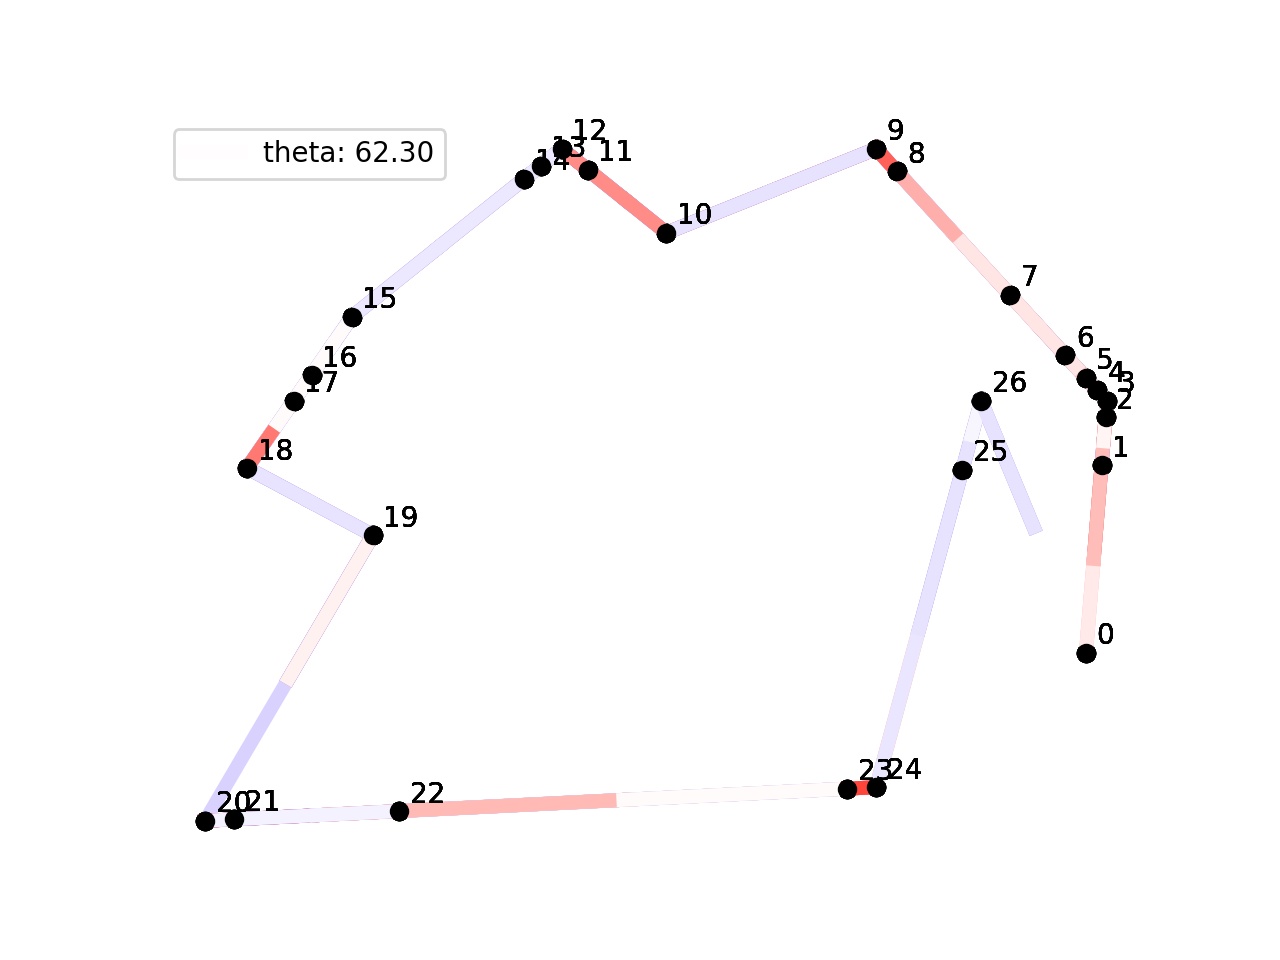

interactive(children=(FloatSlider(value=90.94366926962348, description='theta', max=179.0, min=5.0, step=5.729…

In [57]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
def test_video(theta):
    theta = theta / 180 * np.pi
    poly = Simple_Polygon("sh", poly1[0])
    pprime, data = classifyBoundary(poly, theta)
    outer_vs = [i for i,v in pprime.vertex_list_per_poly[0]]
    outer_data = {i:data[i] for i in data.keys() if i in outer_vs}
    
    plot_poly(outer_vs, outer_data, pprime, ax)

    ax.legend(['theta: {0:.2f}'.format(theta / np.pi * 180)])
    ax.axis('off')
    fig.canvas.draw()
interact(test_video, theta=(5,179, 0.1/np.pi*180));